In [1]:
import sys
!{sys.executable} -m pip install venn
from venn import venn


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import os
import pandas as pd
import math
#from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import numpy as np
from numpy import nan as Nan
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import zipfile
import json
import gzip
import networkx as nx
import seaborn as sns
from collections import Counter, defaultdict
  
plt.rcParams['figure.figsize'] = [12,6]

In [3]:
pwd

'/home/jovyan/IP2AS'

# Load Data

In [4]:
BASEDIR = '../ip-to-as-mapping/aslinks_pipeline/output/'
BASEDIR_LIST = os.listdir(BASEDIR)
HEURISTIC_LIST = ['connAS', 'sidewalk', 'wildcard', 'perfect', 'dropstar', 'publicpatch', 'removeixp', 'fixixp', 'sibling']
MUX_LIST = ['neu01','utah01']

In [5]:
#Unpack by folder and build trace and result dataframes
trace_df_list = []
pipe_df_list = []
for folder in BASEDIR_LIST:
    item = os.path.join(BASEDIR, folder)
    if os.path.isdir(item):
        #Find out which mods are selected
        active_mods = [False]*9
        item_mod_str = folder.split('_')
        #Disregard folders if not well formed
        if len(item_mod_str) != 9:
            continue
            
        #Identify mods used
        #TODO: Need to update method when doing combined heuristics
        mod_s = ""
        for i, s in enumerate(HEURISTIC_LIST):
            if item_mod_str[i] == s:
                active_mods[i] = True
                if item_mod_str[i] == "dropstar":
                    continue
                mod_s = s 
        if mod_s == "":
                mod_s = "classic"
        elif all([active_mods[1],active_mods[4],active_mods[5],active_mods[7]]):
            mod_s = "full_set"
        elif all([active_mods[4],active_mods[5],active_mods[7]]):
            mod_s = "drop_patch_fix"
            
        for mux in MUX_LIST:
            mux_folder = item + "/" + mux
            print("Loading: "+mux+" "+mod_s)

            #traceroute-info
            tmp_df = pd.read_json(mux_folder+"/traceroute-info.gz", lines=True) 
            tmp_df['mux'] = mux
            tmp_df['traceID'] = tmp_df.index
            tmp_df['htype'] = mod_s
            trace_df_list.append(tmp_df)
            
            #classic-bgp-comparison-info
            if mod_s == "connAS" :
                tmp_df = pd.read_json(mux_folder+"/bdrmapit-bgp-comparison-info.gz", lines=True)
            else:
                tmp_df = pd.read_json(mux_folder+"/classic-bgp-comparison-info.gz", lines=True) 
            tmp_df['mux'] = mux
            tmp_df['traceID'] = tmp_df.index
            tmp_df['htype'] = mod_s
            pipe_df_list.append(tmp_df)

            #bdrmapit-bgp-comparison-info: Only for no mods
            if tmp_df['htype'][0] == "classic":
                tmp_df = pd.read_json(mux_folder+"/bdrmapit-bgp-comparison-info.gz", lines=True) 
                tmp_df['mux'] = mux
                tmp_df['traceID'] = tmp_df.index
                tmp_df['htype'] = 'easymapit'
                pipe_df_list.append(tmp_df)

Loading: neu01 perfect
Loading: utah01 perfect
Loading: neu01 publicpatch
Loading: utah01 publicpatch
Loading: neu01 wildcard
Loading: utah01 wildcard
Loading: neu01 sidewalk
Loading: utah01 sidewalk
Loading: neu01 drop_patch_fix
Loading: utah01 drop_patch_fix
Loading: neu01 full_set
Loading: utah01 full_set
Loading: neu01 classic
Loading: utah01 classic
Loading: neu01 connAS
Loading: utah01 connAS
Loading: neu01 sibling
Loading: utah01 sibling
Loading: neu01 fixixp
Loading: utah01 fixixp


In [6]:
#Master Trace DataFrame
TRACE_DF = pd.concat(trace_df_list, ignore_index=True)
TRACE_DF.head()

,ippath,metadata_bdr,metadata_cls,mux,probe_id,rttpath,source,target,timestamp,traceID,htype
0,"[[255.255.255.255], [10.2.29.113], [10.2.29.22...","[star, negative_or_not_mapped, negative_or_not...","[star, negative_or_not_mapped, negative_or_not...",neu01,neu01_traceroutes,"[[-1], [141.301], [142.043], [142.181], [146.8...",warts,34.95.192.178,2024-05-07 22:09:33,0,perfect
1,"[[255.255.255.255], [10.2.29.113], [10.2.29.22...","[star, negative_or_not_mapped, negative_or_not...","[star, negative_or_not_mapped, negative_or_not...",neu01,neu01_traceroutes,"[[-1], [141.915], [141.353], [142.037], [141.7...",warts,1.0.0.238,2024-05-07 22:09:32,1,perfect
2,"[[255.255.255.255], [10.2.29.113], [10.2.29.22...","[star, negative_or_not_mapped, negative_or_not...","[star, negative_or_not_mapped, negative_or_not...",neu01,neu01_traceroutes,"[[-1], [141.318], [141.339], [141.986], [146.9...",warts,34.141.64.99,2024-05-07 22:09:33,2,perfect
3,"[[255.255.255.255], [10.2.29.113], [10.2.29.22...","[star, negative_or_not_mapped, negative_or_not...","[star, negative_or_not_mapped, negative_or_not...",neu01,neu01_traceroutes,"[[-1], [141.162], [141.4], [142.088], [146.794...",warts,34.29.1.209,2024-05-07 22:09:33,3,perfect
4,"[[255.255.255.255], [10.2.29.113], [10.2.29.22...","[star, negative_or_not_mapped, negative_or_not...","[star, negative_or_not_mapped, negative_or_not...",neu01,neu01_traceroutes,"[[-1], [141.303], [141.45], [142.012], [141.79...",warts,104.18.38.242,2024-05-07 22:09:33,4,perfect


In [7]:
TRACE_DF.ippath[0], TRACE_DF.metadata_cls[0]

([['255.255.255.255'],
  ['10.2.29.113'],
  ['10.2.29.226'],
  ['18.2.132.45'],
  ['192.5.89.25'],
  ['18.2.145.18'],
  ['34.95.192.178']],
 ['star',
  'negative_or_not_mapped',
  'negative_or_not_mapped',
  '10578',
  '10578',
  '10578',
  '396982'])

In [8]:
#Master Pipeline DataFrame
PIPELINE_DF = pd.concat(pipe_df_list, ignore_index=True)
PIPELINE_DF.head()

,aspath,aspath_complete,aspath_raw,distance,groundtruth,groundtruth_raw,mux,traceID,htype
0,"[10578, 396982]","[16777216, 18874368, 18874368, 10578, 10578, 1...","[19922947, 10578, 396982]",1,"[10578, 15169, 396982]","[156, 10578, 15169, 396982]",neu01,0,perfect
1,"[7922, 13335]","[16777216, 18874368, 18874368, 7922, 7922, 792...","[19922947, 7922, 13335]",0,"[7922, 13335]","[156, 7922, 13335]",neu01,1,perfect
2,"[10578, 396982]","[16777216, 18874368, 18874368, 10578, 10578, 1...","[19922947, 10578, 396982]",1,"[10578, 15169, 396982]","[156, 10578, 15169, 396982]",neu01,2,perfect
3,"[10578, 396982]","[16777216, 18874368, 18874368, 10578, 10578, 1...","[19922947, 10578, 396982]",1,"[10578, 15169, 396982]","[156, 10578, 15169, 396982]",neu01,3,perfect
4,"[7922, 13335]","[16777216, 18874368, 18874368, 7922, 7922, 792...","[19922947, 7922, 13335]",0,"[7922, 13335]","[156, 7922, 13335]",neu01,4,perfect


In [9]:
PIPELINE_DF.shape

(3413869, 9)

In [10]:
#Master AS to ORG DataFrame
ASORG_DF = pd.read_json('../ip-to-as-mapping/aslinks_pipeline/input_data/ii.as-org.v01.2024-01.json', orient='index')

In [11]:
ASORG_DF

,Status,Reference Orgs,Sibling ASNs,Name,Descr,Website,Comparison with CA2O,Comparison with PDB,PDB.org_id,PDB.org
173,matched,"[{'source': 'PDB', 'name': 'NTT NTLab', 'org_i...","[4697, 4710, 55817]",NTTECL-AS,Nippon Telegraph and Telephone Corporation,,Disagree,Disagree,9637,NTT Network Innovation Laboratories
4697,matched,"[{'source': 'PDB', 'name': 'NTT NTLab', 'org_i...","[173, 4710, 55817]",NTTV6NET,,,Disagree,Disagree,2338,NTT NTLab
4710,matched,"[{'source': 'PDB', 'name': 'NTT NTLab', 'org_i...","[173, 4697, 55817]",NTTV6NET2,,,Disagree,Disagree,9637,NTT Network Innovation Laboratories
55817,matched,"[{'source': 'PDB', 'name': 'NTT NTLab', 'org_i...","[173, 4697, 4710]",NTTECL-AS-AP,Nippon Telegraph and Telephone Corporation PF ...,,Disagree,Disagree,,
1221,matched,"[{'source': 'Whois', 'name': 'Telstra Corporat...","[132029, 132292, 133859, 133931, 135052, 13508...",ASN-TELSTRA,Telstra Corporation Ltd,https://www.telstra.com.au/,Agree,Disagree,22818,Telstra Corporation Ltd
...,...,...,...,...,...,...,...,...,...,...
400908,no hint of error,"[{'source': 'Whois', 'name': 'Videoport IPTV L...",[],XSTREAM-CABLE-TV,,,-,-,,
400909,no hint of error,"[{'source': 'Whois', 'name': 'TRAVCHIS, LLC'}]",[],TRAVCHIS,,,-,-,,
401306,no hint of error,"[{'source': 'Whois', 'name': 'Ingersoll Rand I...",[],IR,,,-,-,,
401307,no hint of error,"[{'source': 'Whois', 'name': 'Michigan Statewi...",[25684],MISEN-ASN-1,,,-,-,30787,Michigan Statewide Educational Network


In [12]:
as_score_df = pd.read_csv('score_ASes_peeringDB_2024_05.csv')
as_score_df

,Unnamed: 0,asn,name,score
0,4632,36917,Angola Comunicacoes & Systems LDA,3
1,7619,265170,GSM TELECOM SERVIÇOS DE PROVEDOR DE INTERNET LTDA,3
2,9796,50453,FotoStrana,3
3,6239,55408,Univision,3
4,16529,208820,DEPARTEMENT DE LA SEINE-SAINT-DENIS,3
...,...,...,...,...
30499,28868,141613,Jaringan Internet Nusantara,24
30500,154,6830,Liberty Global,24
30501,27865,140437,MEDIA MANAKARRA NET,25
30502,19678,150268,BertuahIX Route Servers,25


In [13]:
ASORG_DF['score'] = 0
for i, row in as_score_df.iterrows():
    if (row.asn in ASORG_DF.index):
        ASORG_DF.loc[ASORG_DF.index == row.asn, 'score'] = row.score
        

In [14]:
ASORG_DF

,Status,Reference Orgs,Sibling ASNs,Name,Descr,Website,Comparison with CA2O,Comparison with PDB,PDB.org_id,PDB.org,score
173,matched,"[{'source': 'PDB', 'name': 'NTT NTLab', 'org_i...","[4697, 4710, 55817]",NTTECL-AS,Nippon Telegraph and Telephone Corporation,,Disagree,Disagree,9637,NTT Network Innovation Laboratories,6
4697,matched,"[{'source': 'PDB', 'name': 'NTT NTLab', 'org_i...","[173, 4710, 55817]",NTTV6NET,,,Disagree,Disagree,2338,NTT NTLab,9
4710,matched,"[{'source': 'PDB', 'name': 'NTT NTLab', 'org_i...","[173, 4697, 55817]",NTTV6NET2,,,Disagree,Disagree,9637,NTT Network Innovation Laboratories,3
55817,matched,"[{'source': 'PDB', 'name': 'NTT NTLab', 'org_i...","[173, 4697, 4710]",NTTECL-AS-AP,Nippon Telegraph and Telephone Corporation PF ...,,Disagree,Disagree,,,0
1221,matched,"[{'source': 'Whois', 'name': 'Telstra Corporat...","[132029, 132292, 133859, 133931, 135052, 13508...",ASN-TELSTRA,Telstra Corporation Ltd,https://www.telstra.com.au/,Agree,Disagree,22818,Telstra Corporation Ltd,15
...,...,...,...,...,...,...,...,...,...,...,...
400908,no hint of error,"[{'source': 'Whois', 'name': 'Videoport IPTV L...",[],XSTREAM-CABLE-TV,,,-,-,,,0
400909,no hint of error,"[{'source': 'Whois', 'name': 'TRAVCHIS, LLC'}]",[],TRAVCHIS,,,-,-,,,0
401306,no hint of error,"[{'source': 'Whois', 'name': 'Ingersoll Rand I...",[],IR,,,-,-,,,0
401307,no hint of error,"[{'source': 'Whois', 'name': 'Michigan Statewi...",[25684],MISEN-ASN-1,,,-,-,30787,Michigan Statewide Educational Network,3


In [211]:
ASORG_DF.loc[207531]

Status                                                            matched
Reference Orgs          [{'source': 'Whois', 'name': 'IELO Sarl'}, {'s...
Sibling ASNs                                        [29075, 50618, 57179]
Name                                                              IELO-CH
Descr                                                                    
Website                                            https://ipjetable.net/
Comparison with CA2O                                             Disagree
Comparison with PDB                                              Disagree
PDB.org_id                                                           2287
PDB.org                                           IELO-LIAZO SERVICES SAS
score                                                                   5
Name: 207531, dtype: object

In [16]:
del pipe_df_list
del trace_df_list

In [17]:
#pipeline_df.to_csv('07MAY_pipeline.gz')
#trace_df.to_csv('07MAY_traces.gz')

## Analysis 

In [18]:
#look at a single mux output for now
neu01_traces = TRACE_DF.loc[TRACE_DF["mux"] == "neu01"]
utah01_traces = TRACE_DF.loc[TRACE_DF["mux"] == "utah01"]
sel_traces = neu01_traces
neu01_slice = PIPELINE_DF.loc[PIPELINE_DF['mux'] == 'neu01']
utah01_slice = PIPELINE_DF.loc[PIPELINE_DF['mux'] == 'utah01']
sel_slice = utah01_slice
sel_slice["htype"].value_counts()

htype
publicpatch       147560
wildcard          147560
sidewalk          147560
drop_patch_fix    147560
full_set          147560
classic           147560
easymapit         147560
connAS            147560
sibling           147560
fixixp            147560
perfect            18897
Name: count, dtype: int64

In [19]:
#find any traceIDs that have duplicate ASes
bad_traces = []
classic_slice = sel_slice.loc[sel_slice.htype == 'classic' ]
for idx, row in classic_slice.iterrows():
    if len(row.groundtruth) != len(set(row.groundtruth)):
        bad_traces.append(row.traceID)

In [20]:
len(bad_traces)

38

In [21]:
if len(bad_traces) > 0:
    sel_traces = sel_traces.loc[~sel_traces.traceID.isin(bad_traces) & (sel_traces.htype != 'perfect') ]
    sel_slice = sel_slice.loc[~sel_slice.traceID.isin(bad_traces) & (sel_slice.htype != 'perfect') ]
    sel_slice["htype"].value_counts()

In [22]:
htype_str_full = ['easymapit', 'classic', 'connAS', 'sidewalk', 'wildcard', 'publicpatch', 'fixixp', 'sibling', 'drop_patch_fix', 'full_set'] 
#['easymapit', 'classic', 'connAS', 'sidewalk', 'wildcard', 'perfect', 'dropstar', 'publicpatch', 'removeixp', 'fixixp', 'sibling'] 

In [23]:
#What is the distance to ground truth for single heuristics?
htype_slices = {}
for t in htype_str_full:
    htype_slices[t] = sel_slice[ sel_slice['htype'] == t ]['distance']
dist_counts = {}
for t, slice_df in htype_slices.items():
    dist_counts[t] = slice_df.value_counts()
dist_df = pd.DataFrame(dist_counts)
dist_df = dist_df.fillna(0)

In [24]:
dist_df

,easymapit,classic,connAS,sidewalk,wildcard,publicpatch,fixixp,sibling,drop_patch_fix,full_set
distance,,,,,,,,,,
0,73364.0,68820.0,74507.0,85610,82935.0,75245.0,69108.0,110530.0,75371.0,85713
1,56278.0,54209.0,56743.0,41665,46755.0,50354.0,53928.0,28895.0,50234.0,41558
2,13018.0,17522.0,11616.0,11914,12195.0,15363.0,17527.0,6035.0,15369.0,11909
3,3432.0,5106.0,3162.0,5640,3982.0,4720.0,5094.0,1376.0,4713.0,5648
4,959.0,1279.0,999.0,1839,1088.0,1234.0,1278.0,477.0,1233.0,1845
5,355.0,422.0,362.0,619,406.0,445.0,422.0,168.0,446.0,618
6,99.0,136.0,110.0,175,133.0,125.0,137.0,30.0,125.0,176
7,11.0,16.0,16.0,39,16.0,17.0,17.0,5.0,18.0,39
8,3.0,9.0,4.0,9,9.0,9.0,8.0,4.0,8.0,9


In [25]:
# Generate JSONs of traces that have a large distance
tail_pipe_df = sel_slice.loc[sel_slice.distance > 7]
tail_traces = set(tail_pipe_df.traceID)

In [26]:
tail_trace_df = sel_traces.loc[sel_traces.traceID.isin(tail_traces)]

In [27]:
tail_pipe_df.to_json('utah_tail_pipeline.gz', index=False)
tail_trace_df.to_json('utah_tail_traces.gz', index=False)

In [28]:
tail_pipe_df

,aspath,aspath_complete,aspath_raw,distance,groundtruth,groundtruth_raw,mux,traceID,htype
256359,"[210, 11164, 11537, 22388, 7660, 23855, 24490,...","[16777216, 210, 210, 11164, 11537, 11537, 1887...","[17825793, 210, 11164, 11537, 22388, 7660, 238...",9,"[210, 11164, 20473, 1921]","[210, 11164, 20473, 1921]",utah01,2944,publicpatch
257113,"[210, 11164, 11537, 22388, 7660, 23855, 24490,...","[16777216, 210, 210, 11164, 11537, 11537, 1153...","[17825793, 210, 11164, 11537, 22388, 7660, 238...",10,"[210, 11164, 36236, 207021]","[210, 11164, 36236, 207021]",utah01,3698,publicpatch
265045,"[210, 11164, 11537, 22388, 7660, 23855, 24490,...","[16777216, 210, 210, 11164, 11537, 11537, 1887...","[17825793, 210, 11164, 11537, 22388, 7660, 238...",9,"[210, 11164, 20473, 1921]","[210, 11164, 20473, 1921]",utah01,11630,publicpatch
280312,"[210, 11164, 11537, 22388, 7660, 23855, 24490,...","[16777216, 210, 210, 11164, 11537, 11537, 1887...","[17825793, 210, 11164, 11537, 22388, 7660, 238...",9,"[210, 11164, 20473, 1921]","[210, 11164, 20473, 1921]",utah01,26897,publicpatch
290440,"[210, 11164, 11537, 22388, 7660, 23855, 24490,...","[16777216, 210, 210, 11164, 11537, 11537, 1887...","[17825793, 210, 11164, 11537, 22388, 7660, 238...",9,"[210, 11164, 20473, 1921]","[210, 11164, 20473, 1921]",utah01,37025,publicpatch
...,...,...,...,...,...,...,...,...,...
3353576,"[210, 6939, 3356, 6939, 3356, 6939, 23764, 257...","[16777216, 210, 210, 210, 6939, 16777216, 1677...","[17825793, 210, 6939, 17825794, 3356, 6939, 33...",9,"[210, 174, 30844, 37298]","[210, 174, 30844, 37298]",utah01,87267,fixixp
3355431,"[210, 11164, 11537]","[16777216, 210, 210, 11164, 11537, 11537, 1153...","[17825793, 210, 11164, 11537, 19922950]",8,"[210, 11164, 6461, 52320, 7738, 8167, 262907, ...","[210, 11164, 6461, 52320, 7738, 8167, 262907, ...",utah01,89122,fixixp
3355476,"[210, 6461, 7922, 6762, 174, 37662, 6762, 6453...","[16777216, 210, 210, 210, 6461, 6461, 7922, 79...","[17825793, 210, 6461, 7922, 6762, 174, 37662, ...",9,"[210, 209]","[210, 209]",utah01,89167,fixixp
3384198,"[210, 6939, 3356, 6939, 3356, 6939, 37662, 371...","[16777216, 210, 210, 210, 6939, 6939, 16777216...","[17825793, 210, 6939, 17825793, 3356, 6939, 33...",8,"[210, 174, 6762, 37280]","[210, 174, 6762, 37280]",utah01,117889,fixixp


In [29]:
tail_trace_df

,ippath,metadata_bdr,metadata_cls,mux,probe_id,rttpath,source,target,timestamp,traceID,htype
69153,"[[255.255.255.255], [10.2.29.113], [10.2.29.22...","[star, negative_or_not_mapped, negative_or_not...","[star, negative_or_not_mapped, negative_or_not...",neu01,neu01_traceroutes,"[[-1], [141.91], [141.525], [-1], [-1], [293.1...",warts,190.122.182.63,2024-05-07 22:09:35,2944,publicpatch
69907,"[[255.255.255.255], [10.2.29.113], [10.2.29.22...","[star, negative_or_not_mapped, negative_or_not...","[star, negative_or_not_mapped, negative_or_not...",neu01,neu01_traceroutes,"[[-1], [141.049], [141.417], [-1], [-1], [153....",warts,38.51.31.254,2024-05-07 22:09:34,3698,publicpatch
77839,"[[255.255.255.255], [10.2.29.113], [10.2.29.22...","[star, negative_or_not_mapped, negative_or_not...","[star, negative_or_not_mapped, negative_or_not...",neu01,neu01_traceroutes,"[[-1], [141.601], [141.274], [141.934], [141.8...",warts,45.115.113.45,2024-05-07 22:13:11,11630,publicpatch
93106,"[[255.255.255.255], [10.2.29.113], [10.2.29.22...","[star, negative_or_not_mapped, negative_or_not...","[star, negative_or_not_mapped, negative_or_not...",neu01,neu01_traceroutes,"[[-1], [141.317], [141.409], [142.318], [141.9...",warts,67.211.49.254,2024-05-07 22:19:23,26897,publicpatch
103234,"[[255.255.255.255], [10.2.29.113], [10.2.29.22...","[star, negative_or_not_mapped, negative_or_not...","[star, negative_or_not_mapped, negative_or_not...",neu01,neu01_traceroutes,"[[-1], [141.18], [141.257], [-1], [-1], [148.9...",warts,156.235.28.142,2024-05-07 22:24:26,37025,publicpatch
...,...,...,...,...,...,...,...,...,...,...,...
2843581,"[[255.255.255.255], [10.2.29.113], [10.2.29.22...","[star, negative_or_not_mapped, negative_or_not...","[star, negative_or_not_mapped, negative_or_not...",neu01,neu01_traceroutes,"[[-1], [141.218], [141.445], [-1], [-1], [287....",warts,179.60.128.1,2024-05-07 22:49:11,99244,fixixp
2850582,"[[255.255.255.255], [10.2.29.113], [10.2.29.22...","[star, negative_or_not_mapped, negative_or_not...","[star, negative_or_not_mapped, negative_or_not...",neu01,neu01_traceroutes,"[[-1], [141.773], [141.441], [142.13], [143.18...",warts,103.159.163.85,2024-05-07 22:51:26,106245,fixixp
2855144,"[[255.255.255.255], [10.2.29.113], [10.2.29.22...","[star, negative_or_not_mapped, negative_or_not...","[star, negative_or_not_mapped, negative_or_not...",neu01,neu01_traceroutes,"[[-1], [142.167], [141.357], [142.091], [143.1...",warts,179.51.188.98,2024-05-07 22:53:15,110807,fixixp
2862226,"[[255.255.255.255], [10.2.29.113], [10.2.29.22...","[star, negative_or_not_mapped, negative_or_not...","[star, negative_or_not_mapped, negative_or_not...",neu01,neu01_traceroutes,"[[-1], [141.32], [141.255], [-1], [-1], [150.7...",warts,91.223.96.20,2024-05-07 22:57:19,117889,fixixp


In [30]:
htype_str = ['easymapit', 'connAS', 'classic', 'sidewalk', 'wildcard', 'publicpatch', 'fixixp', 'sibling', 'drop_patch_fix', 'full_set'] 

Text(0.5, 1.0, 'neu01 Fraction of Correct Mappings Compared to Ground Truth')

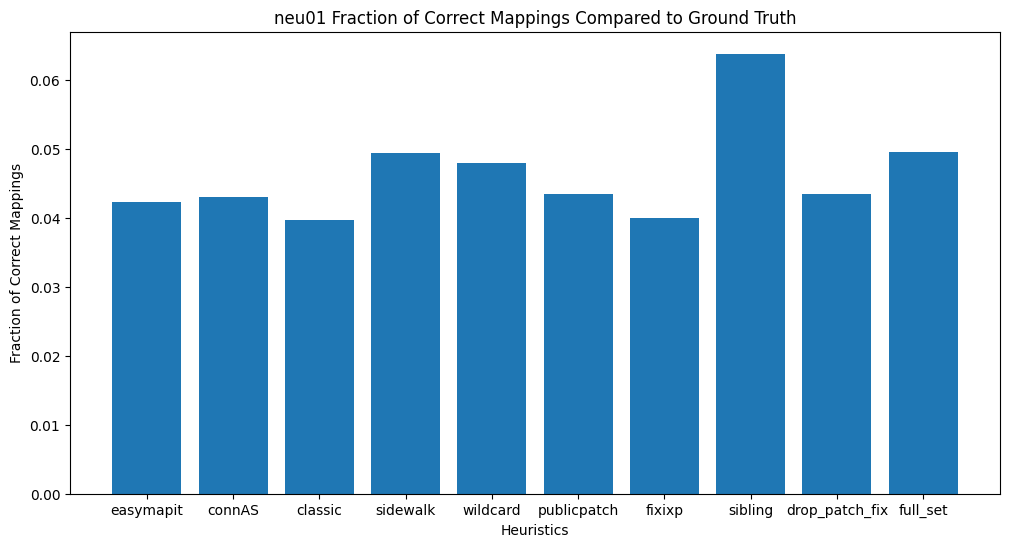

In [31]:
#What is the accuracy of heuristics compared to ground truth?
zero_distance = {}
for t in htype_str:
    zero_distance[t] = dist_df[t][0]/TRACE_DF.loc[TRACE_DF["mux"]=="neu01"].shape[0]
plt.bar(*zip(*zero_distance.items()))
plt.xlabel("Heuristics")
plt.ylabel("Fraction of Correct Mappings")
plt.title("neu01 Fraction of Correct Mappings Compared to Ground Truth")

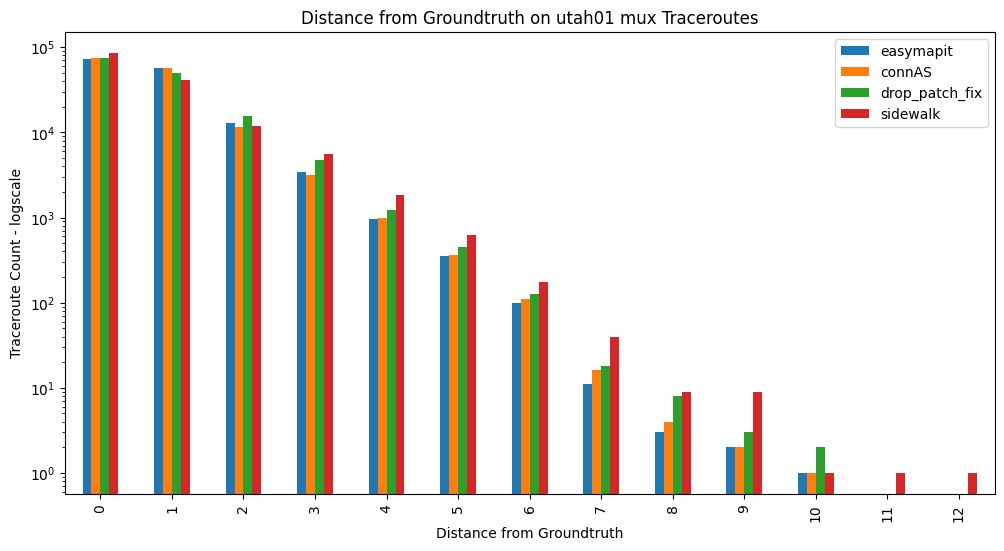

In [32]:
#How is the distance to groundtruth distributed amongst heuristics?
ax = dist_df[["easymapit", "connAS", "drop_patch_fix","sidewalk"]].plot.bar(logy= True, ylabel="Traceroute Count - logscale", xlabel="Distance from Groundtruth", title="Distance from Groundtruth on utah01 mux Traceroutes")
#for container in ax.containers:
#    ax.bar_label(container, rotation=90)

In [33]:
# Create Venn mapping of all correct traceroutes by ID
zd_dict = {}
for t in htype_str:
    zd_dict[t] = set(sel_slice.loc[ (sel_slice["htype"] == t) & (sel_slice["distance"] == 0) ]["traceID"].values)

<Axes: >

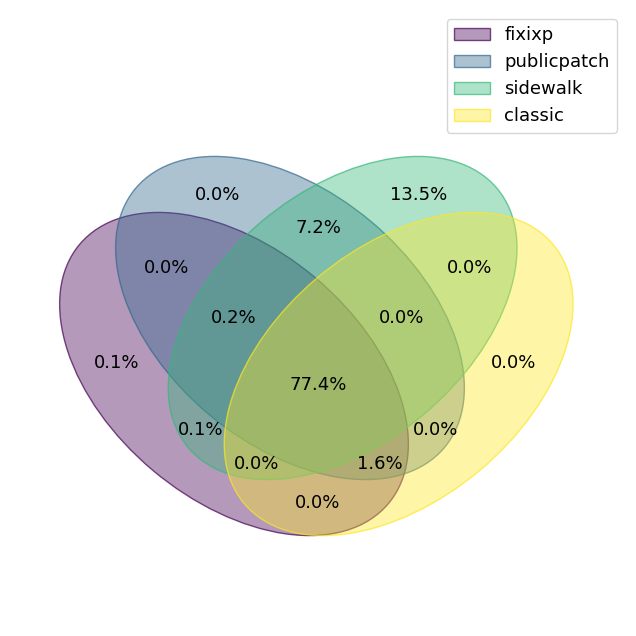

In [34]:
#For correct traceroutes, which ones are unique among different heuristics?
#htype_str = htype_str = ['easymapit', 'connAS', 'classic', 'sidewalk', 'wildcard', 'dropstar', 'publicpatch', 'fixixp', 'sibling'] 
venn_keys = ['fixixp', 'publicpatch','sidewalk', 'classic'] 
venn_dict = {key: zd_dict[key] for key in venn_keys}
venn(venn_dict, fmt="{percentage:.1f}%")

<Axes: >

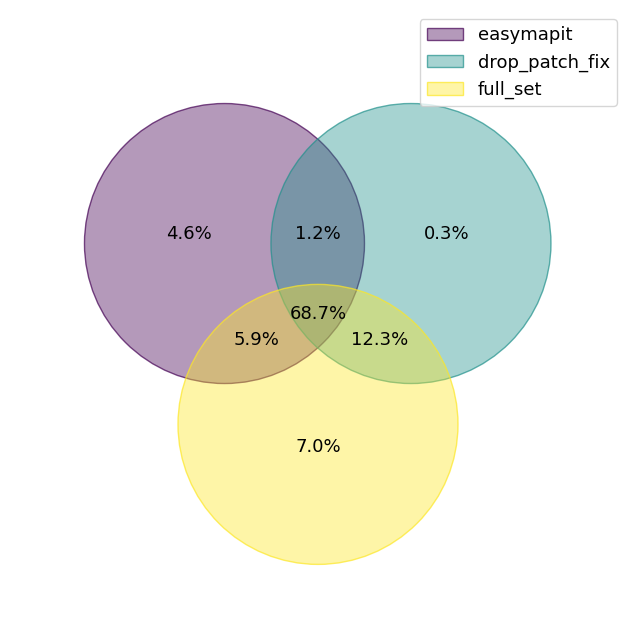

In [35]:
#For correct traceroutes, which ones are unique among different heuristics?

venn_keys = ['easymapit', 'drop_patch_fix', 'full_set'] 
venn_dict = {key: zd_dict[key] for key in venn_keys}
venn(venn_dict, fmt="{percentage:.1f}%")

In [36]:
#Table layout for accuracy determination
comp_str = ['easymapit', 'connAS', 'classic', 'sidewalk', 'publicpatch', 'fixixp', 'drop_patch_fix', 'full_set'] 
#build a list of dictionaries where idx is htype and pairs: {TraceID: distance}
stats_dict = [{} for _ in range(len(comp_str))]
for htype_idx, c_str in enumerate(comp_str):
    tmp_slice = sel_slice.loc[sel_slice.htype == c_str]
    for df_idx, row in tmp_slice.iterrows():
        askey = stats_dict[htype_idx].get(row.traceID, -1)
        if askey != -1:
            print("Duplicate: %s" % askey)
        else:
            stats_dict[htype_idx][row.traceID] = row.distance


In [37]:
len(stats_dict[0])

147522

In [38]:
perfect_comp = [[]]*len(comp_str)
for foundby in range(len(comp_str)): #foundby is row: the metric that found the perfect route
    perfect_comp[foundby] = [0] * len(comp_str)
    for trace, dist in stats_dict[foundby].items():
        if dist > 0:
            continue
        for sharedby in range(len(comp_str)): #sharedby is column: metrics that also found the same route perfect
            if stats_dict[sharedby][trace] == 0:
                perfect_comp[foundby][sharedby] += 1

In [39]:
perfect_df = pd.DataFrame(perfect_comp, columns = comp_str, index = comp_str)
perfect_df

,easymapit,connAS,classic,sidewalk,publicpatch,fixixp,drop_patch_fix,full_set
easymapit,73364,72454,60658,68017,63681,60935,63813,68104
connAS,72454,74507,61651,69510,64938,61933,65069,69600
classic,60658,61651,68820,67399,68810,68814,68804,67408
sidewalk,68017,69510,67399,85610,73820,67608,73867,85603
publicpatch,63681,64938,68810,73820,75245,68948,75221,73830
fixixp,60935,61933,68814,67608,68948,69108,69098,67701
drop_patch_fix,63813,65069,68804,73867,75221,69098,75371,73961
full_set,68104,69600,67408,85603,73830,67701,73961,85713


In [40]:
better_comp = [[]]*len(comp_str)
for foundby in range(len(comp_str)): #foundby is row: the metric that found this route
    better_comp[foundby] = [0] * len(comp_str)
    for trace, dist in stats_dict[foundby].items():
        best = True
        for sharedby in range(len(comp_str)): #sharedby is column: metrics that are compared to.
            if sharedby == foundby: #add this at the end
                continue 
            if stats_dict[sharedby][trace] <= dist:
                better_comp[foundby][sharedby] += 1
                if stats_dict[sharedby][trace] < dist:
                    best = False
        if (best):
            better_comp[foundby][foundby] += 1

In [41]:
better_df = pd.DataFrame(better_comp, columns = comp_str, index = comp_str)
better_df

,easymapit,connAS,classic,sidewalk,publicpatch,fixixp,drop_patch_fix,full_set
easymapit,120623,145191,121273,129774,125591,121565,125734,129852
connAS,142356,123169,120915,129979,125576,121208,125715,130063
classic,132139,134628,109313,139830,146800,147497,146790,139810
sidewalk,122271,125244,122569,128557,131257,122779,131299,147472
publicpatch,127983,130805,138594,140416,117395,138724,147484,140389
fixixp,132134,134629,147198,139756,146646,109600,146815,139830
drop_patch_fix,127989,130812,138440,140326,147352,138760,117530,140401
full_set,122256,125235,122470,147393,131152,122776,131298,128659


In [42]:
perfect_df_p = perfect_df / len(stats_dict[0])

[Text(0.5, 36.58159722222221, 'Shared By'),
 Text(120.58159722222221, 0.5, 'Found By')]

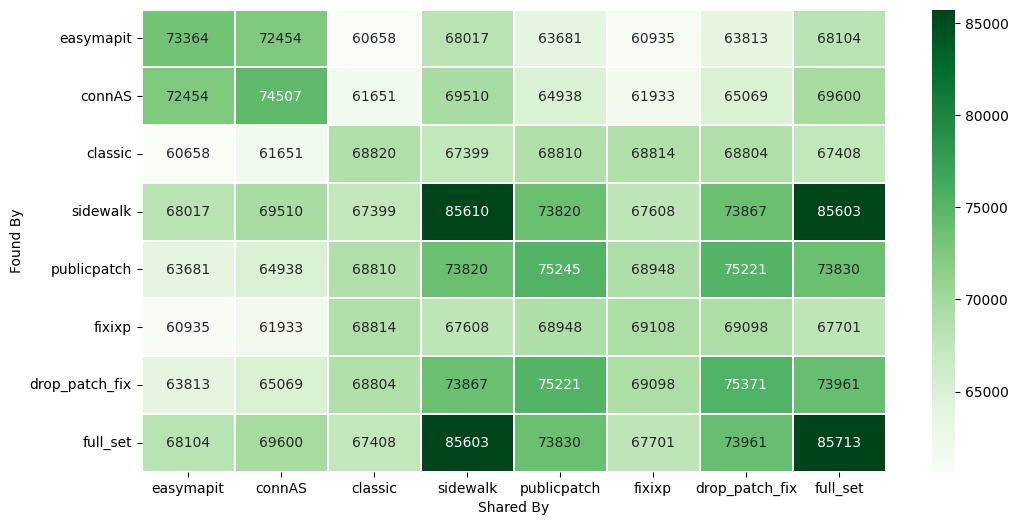

In [43]:
fig, ax = plt.subplots() 
sns.heatmap(perfect_df, cmap ='Greens', linewidths = 0.30, annot = True, fmt = "g") 
ax.set(xlabel="Shared By", ylabel="Found By")
#ax.xaxis.tick_top()

Text(0.5, 1.0, 'Percentage of traces that matched ground truth exactly (utah01)')

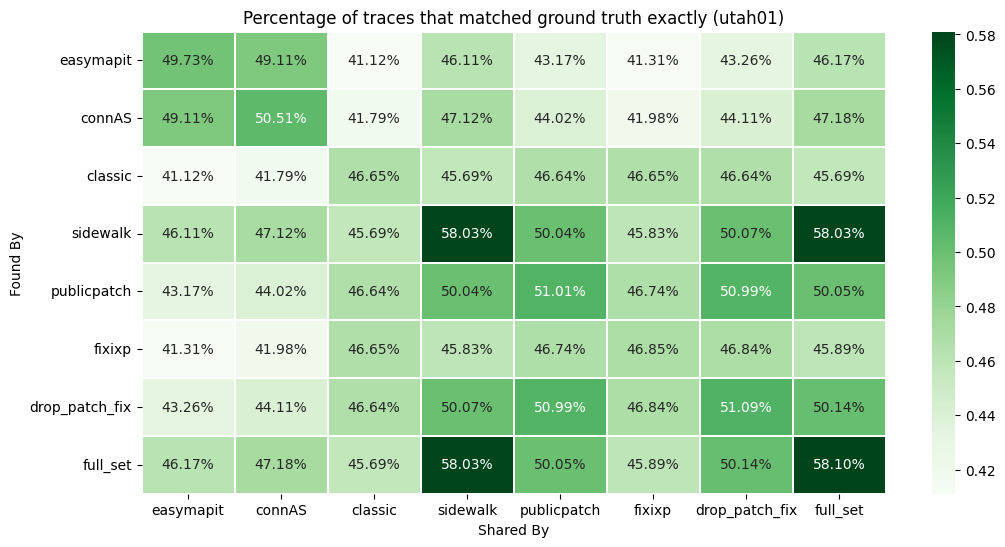

In [44]:
fig, ax = plt.subplots() 
sns.heatmap(perfect_df_p, cmap ='Greens', linewidths = 0.30, annot = True, fmt = ".2%") 
ax.set(xlabel="Shared By", ylabel="Found By")
ax.set_title('Percentage of traces that matched ground truth exactly (utah01)')
#ax.xaxis.tick_top()

Text(0.5, 1.0, 'Heuristics that performed better per trace (utah01)')

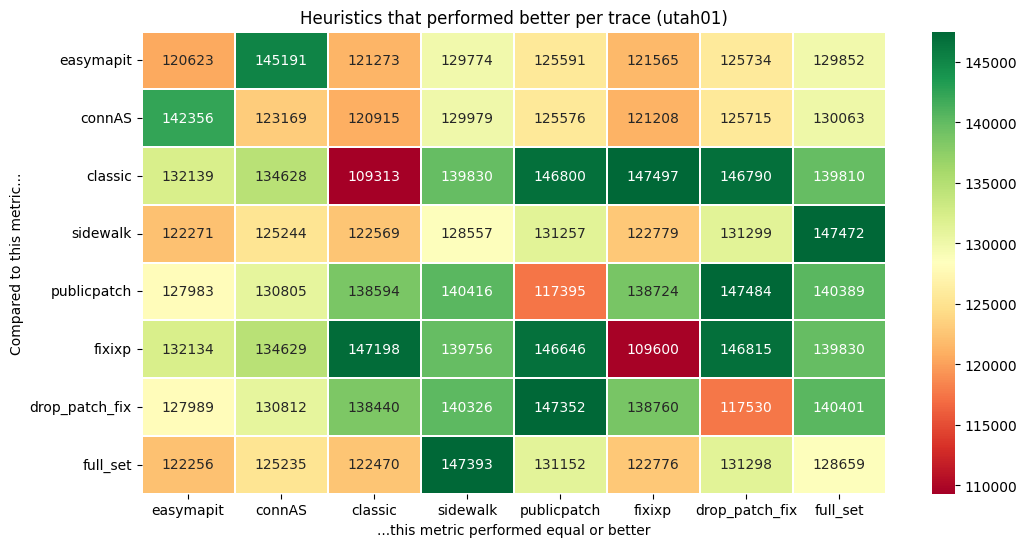

In [45]:
fig, ax = plt.subplots() 
sns.heatmap(better_df, cmap ='RdYlGn', linewidths = 0.3, annot = True, fmt = "g") 
ax.set(xlabel="...this metric performed equal or better", ylabel="Compared to this metric...")
ax.set_title('Heuristics that performed better per trace (utah01)')

Text(0.5, 1.0, 'Heuristics that performed better per trace (utah01)')

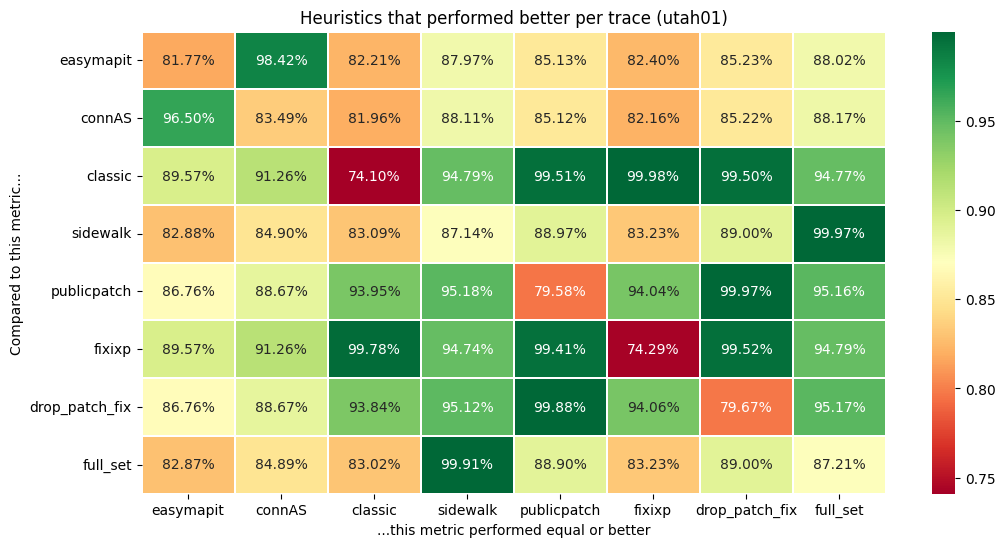

In [46]:
better_df_p = better_df / len(stats_dict[0])
fig, ax = plt.subplots() 
sns.heatmap(better_df_p, cmap ='RdYlGn', linewidths = 0.3, annot = True, fmt = ".2%") 
ax.set(xlabel="...this metric performed equal or better", ylabel="Compared to this metric...")
ax.set_title('Heuristics that performed better per trace (utah01)')

In [47]:
strict_comp = [[]]*len(comp_str)
for foundby in range(len(comp_str)): #foundby is row: the metric that found this route
    strict_comp[foundby] = [0] * len(comp_str)
    for trace, dist in stats_dict[foundby].items():
        best = True
        for sharedby in range(len(comp_str)): #sharedby is column: metrics that are compared to.
            if sharedby == foundby: #add this at the end
                continue 
            if stats_dict[sharedby][trace] <= dist:
                best = False
                if stats_dict[sharedby][trace] < dist:
                    strict_comp[foundby][sharedby] += 1
        if (best):
            strict_comp[foundby][foundby] += 1
strict_df = pd.DataFrame(strict_comp, columns = comp_str, index = comp_str)
strict_df

,easymapit,connAS,classic,sidewalk,publicpatch,fixixp,drop_patch_fix,full_set
easymapit,844,5166,15383,25251,19539,15388,19533,25266
connAS,2331,394,12894,22278,16717,12893,16710,22287
classic,26249,26607,4,24953,8928,324,9082,25052
sidewalk,17748,17543,7692,2,7106,7766,7196,129
publicpatch,21931,21946,722,16265,0,876,170,16370
fixixp,25957,26314,25,24743,8798,0,8762,24746
drop_patch_fix,21788,21807,732,16223,38,707,0,16224
full_set,17670,17459,7712,50,7133,7692,7121,12


Text(0.5, 1.0, 'Heuristics that STRICTLY performed better per trace (utah01)')

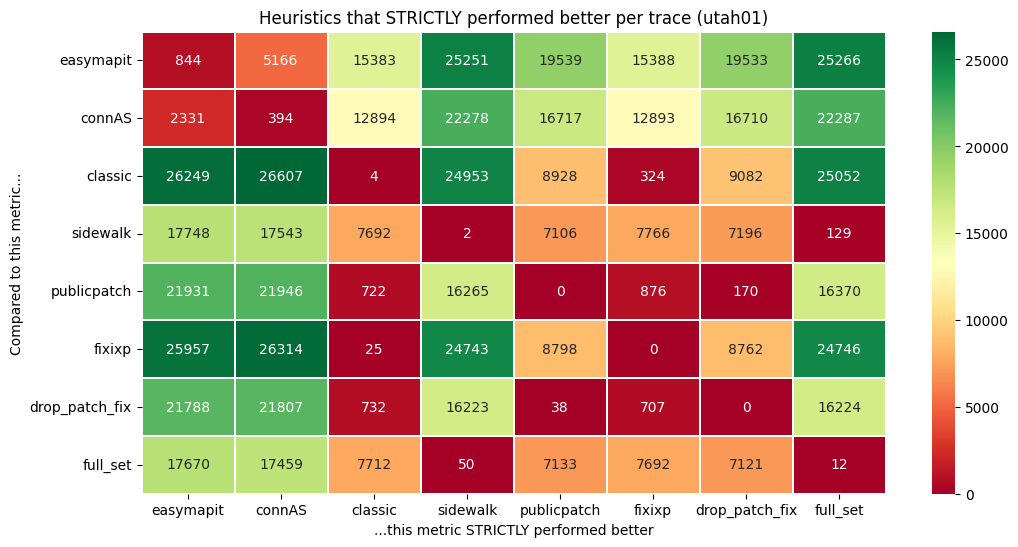

In [48]:
fig, ax = plt.subplots() 
sns.heatmap(strict_df, cmap ='RdYlGn', linewidths = 0.3, annot = True, fmt = "g") 
ax.set(xlabel="...this metric STRICTLY performed better", ylabel="Compared to this metric...")
ax.set_title('Heuristics that STRICTLY performed better per trace (utah01)')

Text(0.5, 1.0, 'Heuristics that STRICTLY performed better per trace (utah01)')

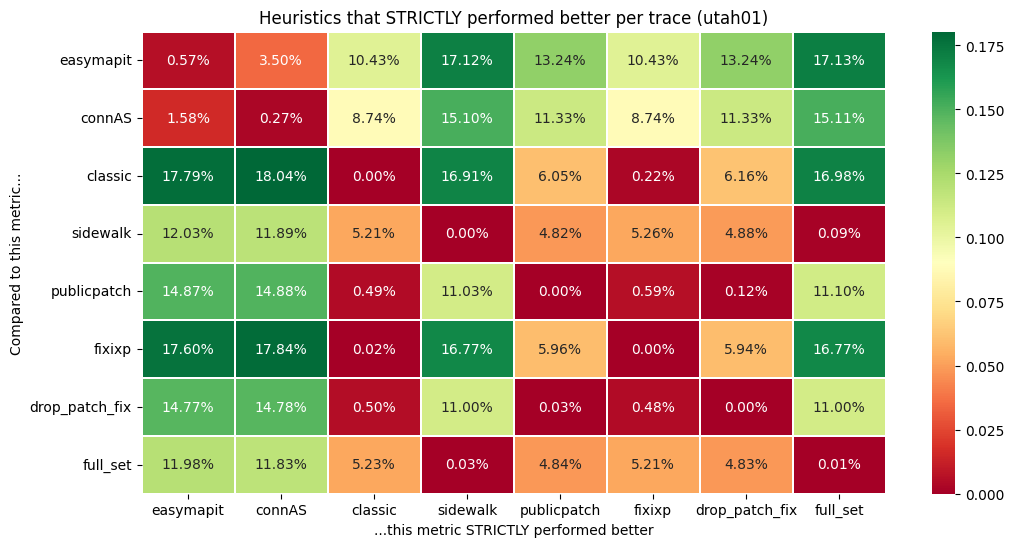

In [49]:
strict_df_p = strict_df / len(stats_dict[0])
fig, ax = plt.subplots() 
sns.heatmap(strict_df_p, cmap ='RdYlGn', linewidths = 0.3, annot = True, fmt = ".2%") 
ax.set(xlabel="...this metric STRICTLY performed better", ylabel="Compared to this metric...")
ax.set_title('Heuristics that STRICTLY performed better per trace (utah01)')

In [50]:
#Calculate error location, htype, and AS
def levenshtein_distance_with_errors(A, B):
    dp = [[0] * (len(B) + 1) for _ in range(len(A) + 1)]
    operations = [[[] for _ in range(len(B) + 1)] for _ in range(len(A) + 1)]

    for i in range(len(A) + 1):
        dp[i][0] = i
        if i > 0:
            operations[i][0] = operations[i-1][0] + [(i-1, 'deletion', A[i-1])]
    
    for j in range(len(B) + 1):
        dp[0][j] = j
        if j > 0:
            operations[0][j] = operations[0][j-1] + [(j-1, 'insertion', B[j-1])]
    
    for i in range(1, len(A) + 1):
        for j in range(1, len(B) + 1):
            if A[i - 1] == B[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
                operations[i][j] = operations[i - 1][j - 1]
            else:
                deletion = dp[i - 1][j] + 1
                insertion = dp[i][j - 1] + 1
                substitution = dp[i - 1][j - 1] + 1
                
                min_op = min(deletion, insertion, substitution)
                dp[i][j] = min_op
                
                if min_op == deletion:
                    operations[i][j] = operations[i - 1][j] + [(i - 1, 'deletion', A[i - 1])]
                elif min_op == insertion:
                    operations[i][j] = operations[i][j - 1] + [(j - 1, 'insertion', B[j - 1])]
                else:
                    operations[i][j] = operations[i - 1][j - 1] + [(i - 1, 'substitution', A[i - 1], B[j - 1])]

    return dp[len(A)][len(B)], operations[len(A)][len(B)]

def find_common_errors(correct_sequence, list_of_sequences):
    error_counter = Counter()
    
    for seq in list_of_sequences:
        _, errors = levenshtein_distance_with_errors(correct_sequence, seq)
        for error in errors:
            if isinstance(error, tuple):
                error_counter[error] += 1
            else:
                print(f"Unexpected error format: {error}")

    return error_counter

def get_as_name(as_num):
    name = ""
    try: 
        name = ASORG_DF.loc[as_num].Name
    except:
        pass
    if name == "" : name = "unknown"
    return name

In [51]:
#Add detailed error information to pipeline_df
def errors_by_row(row):
    truth = row['groundtruth']
    path = row['aspath']
    _, errors = levenshtein_distance_with_errors(truth,path)
    return errors

PIPELINE_DF['errors'] = PIPELINE_DF.apply(errors_by_row, axis=1)
PIPELINE_DF

,aspath,aspath_complete,aspath_raw,distance,groundtruth,groundtruth_raw,mux,traceID,htype,errors
0,"[10578, 396982]","[16777216, 18874368, 18874368, 10578, 10578, 1...","[19922947, 10578, 396982]",1,"[10578, 15169, 396982]","[156, 10578, 15169, 396982]",neu01,0,perfect,"[(1, deletion, 15169)]"
1,"[7922, 13335]","[16777216, 18874368, 18874368, 7922, 7922, 792...","[19922947, 7922, 13335]",0,"[7922, 13335]","[156, 7922, 13335]",neu01,1,perfect,[]
2,"[10578, 396982]","[16777216, 18874368, 18874368, 10578, 10578, 1...","[19922947, 10578, 396982]",1,"[10578, 15169, 396982]","[156, 10578, 15169, 396982]",neu01,2,perfect,"[(1, deletion, 15169)]"
3,"[10578, 396982]","[16777216, 18874368, 18874368, 10578, 10578, 1...","[19922947, 10578, 396982]",1,"[10578, 15169, 396982]","[156, 10578, 15169, 396982]",neu01,3,perfect,"[(1, deletion, 15169)]"
4,"[7922, 13335]","[16777216, 18874368, 18874368, 7922, 7922, 792...","[19922947, 7922, 13335]",0,"[7922, 13335]","[156, 7922, 13335]",neu01,4,perfect,[]
...,...,...,...,...,...,...,...,...,...,...
3413864,"[210, 11164, 11537, 6461, 52320]","[16777216, 210, 210, 11164, 11537, 11537, 1153...","[17825793, 210, 11164, 11537, 19922946, 6461, ...",1,"[210, 11164, 6461, 52320]","[210, 11164, 6461, 52320, 21574, 262306]",utah01,147555,fixixp,"[(2, insertion, 11537)]"
3413865,"[210, 6461]","[16777216, 210, 210, 210, 6461, 6461, 16777216...","[17825793, 210, 6461, 17825797]",0,"[210, 6461]","[210, 6461, 33891, 49666, 41689, 43754, 50810,...",utah01,147556,fixixp,[]
3413866,"[210, 11164, 11537, 6461, 52320]","[16777216, 210, 210, 11164, 11537, 11537, 1153...","[17825793, 210, 11164, 11537, 19922946, 6461, ...",1,"[210, 11164, 6461, 52320]","[210, 11164, 6461, 52320, 28126, 262634, 52729...",utah01,147557,fixixp,"[(2, insertion, 11537)]"
3413867,"[210, 11164, 11537, 6461, 52320]","[16777216, 210, 210, 11164, 11537, 11537, 1153...","[17825793, 210, 11164, 11537, 19922946, 6461, ...",1,"[210, 11164, 6461, 52320]","[210, 11164, 6461, 52320, 21574, 266556]",utah01,147558,fixixp,"[(2, insertion, 11537)]"


In [52]:
# errors_df lists errors: Count, location in sequence, htype, specific AS, mux, and heuristic
err_df_list = []
htype_list = ['easymapit', 'sidewalk', 'drop_patch_fix']

for mux in MUX_LIST:
    mux_split = PIPELINE_DF.loc[PIPELINE_DF.mux == mux]
    
    for h_type in htype_list:
        pipe_slice = mux_split.loc[mux_split['htype']==h_type]
        err_counter = Counter()
        for idx, row in pipe_slice.iterrows():
            errors = row.errors
            for err in errors:
                err_counter[err] += 1
                
        seq = []
        err_type = []
        as_err = []
        as_correct = []
        name_err = []
        name_correct = []
        err_count = []
        for err, count in err_counter.most_common():
            seq.append(err[0])
            err_type.append(err[1])
            err_count.append(count)
            if err[1] == 'deletion':
                as_err.append(0)
                name_err.append('---')
                as_correct.append(err[2])
                name_correct.append(get_as_name(err[2]))
            elif err[1] == 'insertion':
                as_err.append(err[2])
                name_err.append(get_as_name(err[2]))
                as_correct.append(0)
                name_correct.append('---')
            elif err[1] == 'substitution':
                as_err.append(err[3])
                name_err.append(get_as_name(err[3]))
                as_correct.append(err[2])
                name_correct.append(get_as_name(err[2]))

        data={'count':err_count,'sequence':seq,'error_type':err_type,'as_err':as_err,'as_correct':as_correct,'name_err':name_err,'name_correct':name_correct}
        e_df = pd.DataFrame(data=data)
        e_df['htype'] = h_type
        e_df['mux'] = mux
        err_df_list.append(e_df)

errors_df = pd.concat(err_df_list, ignore_index=True)
errors_df

,count,sequence,error_type,as_err,as_correct,name_err,name_correct,htype,mux
0,36969,2,insertion,11537,0,INTERNET2-RESEARCH-EDU,---,easymapit,neu01
1,16704,1,insertion,1299,0,TWELVE99,---,easymapit,neu01
2,6667,2,insertion,1299,0,TWELVE99,---,easymapit,neu01
3,5522,0,substitution,3549,156,LVLT-3549,NORTHEASTERN-GW-AS,easymapit,neu01
4,5515,3,insertion,1299,0,TWELVE99,---,easymapit,neu01
...,...,...,...,...,...,...,...,...,...
69855,1,4,substitution,55836,9583,RELIANCEJIO-IN,SIFY-AS-IN,drop_patch_fix,utah01
69856,1,5,deletion,0,207125,---,DGPCO,drop_patch_fix,utah01
69857,1,4,substitution,12389,12880,ROSTELECOM-AS,DCI-AS,drop_patch_fix,utah01
69858,1,5,deletion,0,202251,---,Padiz-Daderesan-Company-RSPN,drop_patch_fix,utah01


In [53]:
eval_htype = 'drop_patch_fix' #Add easymapit
#Which heuristic to focus on?
errors_slice = errors_df
errors_slice = errors_slice.loc[errors_slice.htype == eval_htype]

#Which has the greatest amount of errors for all muxes? (Max of min amongst muxes)
errors_ins = errors_slice.loc[errors_slice.error_type == 'insertion']
neu01_ins_count = errors_ins.loc[errors_ins.mux == 'neu01'].groupby('as_err')['count'].sum().reset_index().sort_values(by='count', ascending=False).reset_index(drop=True)
utah01_ins_count = errors_ins.loc[errors_ins.mux == 'utah01'].groupby('as_err')['count'].sum().reset_index().sort_values(by='count', ascending=False).reset_index(drop=True)
merged_ins_count = pd.merge(neu01_ins_count, utah01_ins_count, on='as_err', suffixes=('_neu01', '_utah01'))
merged_ins_count['min_errors'] = merged_ins_count[['count_neu01','count_utah01']].min(axis=1)
merged_ins_count = merged_ins_count.sort_values(by='min_errors',ascending=False).reset_index(drop=True)

errors_del = errors_slice.loc[errors_slice.error_type == 'deletion']
neu01_del_count = errors_del.loc[errors_del.mux == 'neu01'].groupby('as_correct')['count'].sum().reset_index().sort_values(by='count', ascending=False).reset_index(drop=True)
utah01_del_count = errors_del.loc[errors_del.mux == 'utah01'].groupby('as_correct')['count'].sum().reset_index().sort_values(by='count', ascending=False).reset_index(drop=True)
merged_del_count = pd.merge(neu01_del_count, utah01_del_count, on='as_correct', suffixes=('_neu01', '_utah01'))
merged_del_count['min_errors'] = merged_del_count[['count_neu01','count_utah01']].min(axis=1)
merged_del_count = merged_del_count.sort_values(by='min_errors',ascending=False).reset_index(drop=True)

errors_sub = errors_slice.loc[errors_slice.error_type == 'substitution']
neu01_sub_err = errors_sub.loc[errors_sub.mux == 'neu01'].groupby('as_err')['count'].sum().reset_index().sort_values(by='count', ascending=False).reset_index(drop=True)
utah01_sub_err = errors_sub.loc[errors_sub.mux == 'utah01'].groupby('as_err')['count'].sum().reset_index().sort_values(by='count', ascending=False).reset_index(drop=True)
merged_sub_err = pd.merge(neu01_sub_err, utah01_sub_err, on='as_err', suffixes=('_neu01', '_utah01'))
merged_sub_err['min_errors'] = merged_sub_err[['count_neu01','count_utah01']].min(axis=1)
merged_sub_err = merged_sub_err.sort_values(by='min_errors',ascending=False).reset_index(drop=True)

neu01_sub_cor = errors_sub.loc[errors_sub.mux == 'neu01'].groupby('as_correct')['count'].sum().reset_index().sort_values(by='count', ascending=False).reset_index(drop=True)
utah01_sub_cor = errors_sub.loc[errors_sub.mux == 'utah01'].groupby('as_correct')['count'].sum().reset_index().sort_values(by='count', ascending=False).reset_index(drop=True)
merged_sub_cor = pd.merge(neu01_sub_cor, utah01_sub_cor, on='as_correct', suffixes=('_neu01', '_utah01'))
merged_sub_cor['min_errors'] = merged_sub_cor[['count_neu01','count_utah01']].min(axis=1)
merged_sub_cor = merged_sub_cor.sort_values(by='min_errors',ascending=False).reset_index(drop=True)

In [134]:
AS_eval_len = 10
AS_eval_df = pd.DataFrame(data={'insertion': merged_ins_count.as_err.head(AS_eval_len), 'deletion':merged_del_count.as_correct.head(AS_eval_len), 'sub_err':merged_sub_err.as_err.head(AS_eval_len), 'sub_corr':merged_sub_cor.as_correct.head(AS_eval_len)})
AS_eval_df

,insertion,deletion,sub_err,sub_corr
0,11537,9498,11537,6461
1,3549,4755,3549,137409
2,3356,52320,7578,9318
3,4845,20940,174,49666
4,7473,53013,6939,19551
5,4991,49666,29049,22927
6,1239,33491,3356,53013
7,1299,9730,10834,15830
8,207531,29119,201011,10490
9,7578,9049,11164,9885


In [215]:
ASORG_DF.loc[52320]

Status                                                            matched
Reference Orgs          [{'source': 'CA2O', 'url': 'http://api.asrank....
Sibling ASNs                                                 [7738, 8167]
Name                                                                     
Descr                                                                    
Website                                               http://www.vtal.com
Comparison with CA2O                                             Disagree
Comparison with PDB                                                 Agree
PDB.org_id                                                           3168
PDB.org                                                              Vtal
score                                                                  17
Name: 52320, dtype: object

In [214]:
AS_eval_name = AS_eval_df.copy().astype(str)
for col in AS_eval_df.columns.values.tolist():
    for row in range(len(AS_eval_df)):
        this_as = AS_eval_df.loc[row,col]
        AS_eval_name.loc[row,col] = ASORG_DF.loc[this_as].Name
AS_eval_name

,insertion,deletion,sub_err,sub_corr
0,INTERNET2-RESEARCH-EDU,BBIL-AP,INTERNET2-RESEARCH-EDU,ZAYO-6461
1,LVLT-3549,TATACOMM-AS,LVLT-3549,GSLNETWORKS-AS-AP
2,LEVEL3,,GSL,SKB-AS
3,SINGTEL-TW,AKAMAI-ASN1,COGENT-174,TIC-GW-AS
4,SINGTEL-AS-AP,,HURRICANE,INCAPSULA
5,COGENT-4991-4994,TIC-GW-AS,Delta-Telecom-AS,
6,SPRINTLINK,COMCAST-33491,LEVEL3,
7,TWELVE99,BHARTITELESONIC-AS-IN-AP,,Equinix
8,IELO-CH,SERVIHOSTING-AS,CORE-BACKBONE,SOUTHERN-CROSSROADS-SOX
9,GSL,ERTH-TRANSIT-AS,INTERNET2-I2PX,NKN-INTERNET-GW


In [217]:
#eval_slice contains a specific heuristic, and every error of a particular AS
#does this list have this error type and AS?
def error_match(error_list, err_type, as_value):
    if (err_type == 'insertion'):
        for err in error_list:
            if err[1] == 'insertion' and err[2] == as_value:
                return True
        return False
    elif (err_type == 'deletion'):
        for err in error_list:
            if err[1] == 'deletion' and err[2] == as_value:
                return True
        return False
    elif (err_type == 'sub_err'):
        for err in error_list:
            if err[1] == 'substitution' and err[3] == as_value:
                return True
        return False
    elif (err_type == 'sub_corr'):
        for err in error_list:
            if err[1] == 'substitution' and err[2] == as_value:
                return True
        return False


#We want the evaluation IP:AS, preceeding IP:AS, following IP:AS, sequence number, IPs involved exclusively in the error traces
#Want to compare heuristic performance for each
def evaluate_AS_errors(eval_as, eval_htype, eval_error):

    htype_slice = PIPELINE_DF.loc[PIPELINE_DF.htype == eval_htype]
    eval_df = htype_slice.loc[htype_slice.errors.apply(lambda x: error_match(x,eval_error, eval_as))]
    print("Errors to parse: %d" % len(eval_df))
    
    seq_counter = Counter()
    pre_AS_counter = Counter()
    post_AS_counter = Counter()
    ip_trace_counter = Counter()
    as_meta_counter = Counter()
    mux_counter = Counter()
    
    for idx, row in eval_df.iterrows():
        #make stats
        #these are already given
        #eval_AS
        #eval_htype
        eval_mux = row.mux
        traceID = row.traceID
        
        #get the correct error, get sequence
        seqnum = None
        if (eval_error == 'sub_err'):
            for err in row.errors:
                if len(err)<4:
                    continue
                if err[3] == eval_AS:
                    seqnum = err[0]
                    break
        else:
            for err in row.errors:
                if err[2] == eval_AS:
                    seqnum = err[0]
                    break

        if seqnum == None:
            raise Exception (f"traceID:{traceID}, mux:{eval_mux}")
        
        #get the preceeding AS
        if seqnum > 0 and len(row.aspath) >= seqnum:
            pre_AS = row.aspath[seqnum-1]
        else:
            pre_AS = 0
    
        #get the following AS
        if seqnum < len(row.aspath)-1:
            post_AS = row.aspath[seqnum+1]
        else:
            post_AS = 0
    
        #pull the matching trace
        trace = TRACE_DF.loc[(TRACE_DF.mux == eval_mux) & (TRACE_DF.htype == eval_htype) & (TRACE_DF.traceID == traceID) ]
    
        #get the offending IP - TODO
    
        #get the IP trace set from preceeding to following
        idx_start = trace.metadata_cls.values[0].index(str(pre_AS)) if str(pre_AS) in trace.metadata_cls.values[0] else 0
        idx_stop  = len(trace.metadata_cls.values[0]) - 1 - trace.metadata_cls.values[0][::-1].index(str(post_AS)) if str(post_AS) in trace.metadata_cls.values[0] else len(trace.metadata_cls.values[0])-1
    
        ip_trace = [lst[0] for lst in trace.ippath.values[0][idx_start:idx_stop+1]]
        as_meta  = trace.metadata_cls.values[0][idx_start:idx_stop+1]
    
        seq_counter[seqnum] += 1
        pre_AS_counter[pre_AS] += 1
        post_AS_counter[post_AS] += 1
        ip_trace_counter[tuple(ip_trace)] += 1
        as_meta_counter[tuple(as_meta)] += 1
        mux_counter[eval_mux] += 1
        
    
    #transform into df row
    eval_name = get_as_name(eval_as)
    seq_clist = Counter(dict(seq_counter.most_common()))
    pre_AS_clist = Counter(dict(pre_AS_counter.most_common()))
    post_AS_clist = Counter(dict(post_AS_counter.most_common()))
    ip_trace_clist = Counter(dict(ip_trace_counter.most_common()))
    as_meta_clist = Counter(dict(as_meta_counter.most_common()))
    mux_clist = Counter(dict(mux_counter.most_common()))
    out_dict = {'AS':eval_as, 'name':eval_name, 'htype':eval_htype, 'mux':mux_clist, 'error_type':eval_error, 'sequence':seq_clist, 'pre_AS':pre_AS_clist, 'post_AS':post_AS_clist,'ip_trace':ip_trace_clist,'as_meta':as_meta_clist}
    return out_dict

In [218]:
eval_err = 'sub_err'
eval_AS = AS_eval_df[eval_err][9]

result = evaluate_AS_errors(eval_AS, eval_htype, eval_err)
result_df = pd.DataFrame({k: [v] for k, v in result.items()})

Errors to parse: 194


In [219]:
result_df

,AS,name,htype,mux,error_type,sequence,pre_AS,post_AS,ip_trace,as_meta
0,11164,INTERNET2-I2PX,drop_patch_fix,"{'neu01': 116, 'utah01': 78}",sub_err,"{1: 188, 3: 3, 2: 2, 0: 1}","{10578: 112, 210: 75, 7922: 2, 11537: 2, 3257:...","{11537: 177, 1828: 9, 35280: 2, 2152: 2, 11164...","{('18.2.132.45', '192.5.89.21', '198.71.47.57'...","{('210', '210', '11164', '11537', '11537', '11..."


In [ ]:
etype_list = ["insertion","deletion","sub_err","sub_corr"]
htype_list = ["drop_patch_fix","connAS"]
topk = 5 #How deep will we go for analysis

result_df_list = []
for k in range(topk):
    for htype in htype_list:
        for etype in etype_list:
            eval_AS = AS_eval_df[etype][k]
            result = evaluate_AS_errors(eval_AS, htype, etype)
            result_df_list.append(pd.DataFrame({k: [v] for k, v in result.items()}))
        print(f"{htype} #{k} Complete.")

topk_AS_eval_df = pd.concat(result_df_list)

Errors to parse: 78961


In [ ]:
topk_AS_eval_df

In [195]:
htype_slice = PIPELINE_DF.loc[PIPELINE_DF.htype == eval_htype]
eval_df = htype_slice.loc[htype_slice.errors.apply(lambda x: error_match(x,eval_err, eval_AS))]
eview = eval_df.loc[eval_df.traceID == 7345]
eview

,aspath,aspath_complete,aspath_raw,distance,groundtruth,groundtruth_raw,mux,traceID,htype,errors
1077852,"[10578, 11164, 11537, 4637, 133772]","[16777216, 18874368, 18874368, 10578, 10578, 1...","[19922947, 10578, 11164, 11537, 18874369, 4637...",5,"[156, 3356]","[156, 3356]",neu01,7345,drop_patch_fix,"[(0, substitution, 156, 10578), (1, substituti..."


In [196]:
eview.errors.values

array([list([(0, 'substitution', 156, 10578), (1, 'substitution', 3356, 11164), (2, 'insertion', 11537), (3, 'insertion', 4637), (4, 'insertion', 133772)])],
      dtype=object)

In [62]:
#Make JSONs with IP to AS mappings for each heuristic
htype_list = ['easymapit'] + list(set(TRACE_DF.htype))

for htype in htype_list:
    
    map_dict = {}
    metacol = 'metadata_cls'
    if htype == 'easymapit' or htype == 'connAS':
        metacol = 'metadata_bdr'
    if htype == 'easymapit':
        tslice_df = TRACE_DF.loc[TRACE_DF['htype'] == 'classic']
    else:
        tslice_df = TRACE_DF.loc[TRACE_DF['htype'] == htype]
        
    for tidx, trace in tslice_df.iterrows():
        ippath = trace.ippath
        metadata = trace[metacol]
        for ipidx, ip_list in enumerate(ippath):
            meta = metadata[ipidx]
            for ip in ip_list:
                map_dict[ip] = meta
    filen = htype +'ip2as_map.gz'
    with open(filen, 'w') as json_file:
        json.dump(map_dict, json_file)
    
    

In [65]:
max_stars = 2
htype_list = ['drop_patch_fix']
for mux in MUX_LIST:
    mux_pipe_df = PIPELINE_DF.loc[PIPELINE_DF.mux == mux]
    mux_trace_df = TRACE_DF.loc[PIPELINE_DF.mux == mux]
    for htype in htype_list: #Does not work for easymapit or connAS as coded
        htype_df = mux_pipe_df.loc[mux_pipe_df.htype == htype].copy()
        ht_trace_df = mux_trace_df.loc[mux_trace_df.htype == htype]
        idx_zeroes = htype_df.index[htype_df['distance'] == 0].tolist()
        htype_df.drop(idx_zeroes,inplace=True)
        miss_traceIDs = htype_df.sort_values(by=['distance'],ascending=False).traceID.tolist()
        miss_trace_df = ht_trace_df.loc[ht_trace_df['traceID'].isin(miss_traceIDs)].copy()


        candidate_traces = []
        for idx, trace in miss_trace_df.iterrows():
            metadata = trace.metadata_cls
            stars = metadata.count('star')
            if stars <= max_stars:
                candidate_traces.append(trace.traceID)
        fname = f"{mux}-{htype}"
        cand_pipe_df = htype_df.loc[htype_df['traceID'].isin(candidate_traces)]
        cand_pipe_df.to_csv(fname+'-pipeline.csv',index=False)
        cand_trace_df= miss_trace_df.loc[miss_trace_df['traceID'].isin(candidate_traces)]
        cand_trace_df.to_csv(fname+'-traces.csv',index=False)
        

In [66]:
cand_pipe_df

,aspath,aspath_complete,aspath_raw,distance,groundtruth,groundtruth_raw,mux,traceID,htype,errors
1257718,"[210, 11164, 11537, 6327]","[16777216, 210, 210, 11164, 11537, 11537, 6327...","[17825793, 210, 11164, 11537, 6327]",1,"[210, 11164, 6327]","[210, 11164, 6327]",utah01,5,drop_patch_fix,"[(2, insertion, 11537)]"
1257725,"[210, 11164, 11537, 137443]","[16777216, 210, 210, 11164, 11537, 11537, 1153...","[17825793, 210, 11164, 11537, 18874369, 137443]",1,"[210, 11164, 21859, 137443]","[210, 11164, 21859, 137443]",utah01,12,drop_patch_fix,"[(2, substitution, 21859, 11537)]"
1257727,"[210, 209, 3356, 3549, 3356, 53010]","[16777216, 210, 210, 209, 209, 3356, 3549, 335...","[17825793, 210, 209, 3356, 3549, 3356, 53010]",2,"[210, 209, 3356, 53010]","[210, 209, 3356, 53010]",utah01,14,drop_patch_fix,"[(2, insertion, 3356), (3, insertion, 3549)]"
1257728,"[210, 11164, 11537, 6327]","[16777216, 210, 210, 11164, 11537, 11537, 6327...","[17825793, 210, 11164, 11537, 6327]",1,"[210, 11164, 6327]","[210, 11164, 6327]",utah01,15,drop_patch_fix,"[(2, insertion, 11537)]"
1257729,"[210, 209, 3356, 3549, 3356, 267250]","[16777216, 210, 210, 209, 209, 3356, 3549, 335...","[17825793, 210, 209, 3356, 3549, 3356, 1887436...",2,"[210, 209, 3356, 268355, 267250]","[210, 209, 3356, 268355, 267250]",utah01,16,drop_patch_fix,"[(3, substitution, 268355, 3549), (4, insertio..."
...,...,...,...,...,...,...,...,...,...,...
1404182,"[210, 11164, 11537, 7473, 4845, 7473, 38193, 5...","[16777216, 210, 210, 11164, 11537, 11537, 1153...","[17825793, 210, 11164, 11537, 18874369, 7473, ...",3,"[210, 11164, 7473, 38193, 58470, 131471]","[210, 11164, 7473, 38193, 58470, 131471]",utah01,146469,drop_patch_fix,"[(2, insertion, 11537), (3, insertion, 7473), ..."
1404187,"[210, 6461, 1299, 47983]","[16777216, 210, 210, 210, 6461, 6461, 16777216...","[17825793, 210, 6461, 1299, 47983]",1,"[210, 6461, 1299, 20904, 47983]","[210, 6461, 1299, 20904, 47983]",utah01,146474,drop_patch_fix,"[(3, deletion, 20904)]"
1404188,"[210, 11164, 11537, 7473, 4845, 7473, 9930, 24...","[16777216, 210, 210, 11164, 11537, 11537, 1153...","[17825793, 210, 11164, 11537, 18874369, 7473, ...",3,"[210, 11164, 7473, 9930, 24218, 45668]","[210, 11164, 7473, 9930, 24218, 45668]",utah01,146475,drop_patch_fix,"[(2, insertion, 11537), (3, insertion, 7473), ..."
1404219,"[210, 11164, 11537, 3491, 5536]","[16777216, 210, 210, 11164, 11537, 11537, 1153...","[17825793, 210, 11164, 11537, 17825793, 3491, ...",2,"[210, 11164, 3491, 60068, 5536]","[210, 11164, 3491, 60068, 5536]",utah01,146506,drop_patch_fix,"[(2, insertion, 11537), (3, deletion, 60068)]"


In [68]:
#What traces (by IDs) were incorrect?
miss_types =['easymapit','sidewalk', 'drop_patch_fix']
miss_list = [] #index is the miss distance threshold. [0] is distance 1 is closest, [8] is all distances greater than 8
all_miss_list = []
for m in range(9):
    miss_list.append({})
    all_miss_list.append({})
    for t in miss_types:
        miss_list[m][t] = set(sel_slice.loc[ (sel_slice["htype"] == t) & (sel_slice["distance"] > m) ]["traceID"].values)
    all_miss_list[m] = set.intersection(*miss_list[m].values())
    if m > 0:
        all_miss_list[m-1] = all_miss_list[m-1]-all_miss_list[m]

In [69]:
all_miss_list[8]

{86762, 89167, 147429}

In [70]:
all_miss_count = {(x+1):len(all_miss_list[x]) for x in range(9)}
all_miss_count #Every heuristic missed these. Minimum miss distance is the dictionary key. 9 is 9+ (to 16)

{1: 48668, 2: 5309, 3: 1464, 4: 535, 5: 209, 6: 49, 7: 5, 8: 0, 9: 3}

In [71]:
#What is the total miss rate?
total_misses = 0
for x in range(9):
    total_misses += len(all_miss_list[x])
total_misses/ sel_slice.loc[ sel_slice["htype"] == "easymapit" ].shape[0]

0.3812448312794024

In [72]:
missed_traces = []
for m in range(9):
    missed_traces.append(sel_slice.loc[sel_slice["traceID"].isin(all_miss_list[m]) ])

In [73]:
missed_traces[8].iloc[0]

aspath             [210, 6939, 3356, 6939, 12389, 29049, 49832, 2...
aspath_complete    [16777216, 210, 210, 210, 6939, 16777216, 1677...
aspath_raw         [17825793, 210, 6939, 3356, 6939, 12389, 17825...
distance                                                          10
groundtruth            [210, 7922, 6762, 49666, 41689, 43754, 44932]
groundtruth_raw        [210, 7922, 6762, 49666, 41689, 43754, 44932]
mux                                                           utah01
traceID                                                        86762
htype                                                    publicpatch
Name: 340177, dtype: object

In [74]:
total_missed_df = pd.concat( [missed_traces[x] for x in range(9)],  ignore_index=True)

In [75]:
all_miss_list[8]

{86762, 89167, 147429}

In [76]:

sel_slice.loc[sel_slice["traceID"].isin(all_miss_list[8])].head(10)

,aspath,aspath_complete,aspath_raw,distance,groundtruth,groundtruth_raw,mux,traceID,htype
340177,"[210, 6939, 3356, 6939, 12389, 29049, 49832, 2...","[16777216, 210, 210, 210, 6939, 16777216, 1677...","[17825793, 210, 6939, 3356, 6939, 12389, 17825...",10,"[210, 7922, 6762, 49666, 41689, 43754, 44932]","[210, 7922, 6762, 49666, 41689, 43754, 44932]",utah01,86762,publicpatch
342582,"[210, 6461, 7922, 6762, 174, 37662, 6762, 6453...","[16777216, 210, 210, 210, 6461, 6461, 7922, 79...","[17825793, 210, 6461, 7922, 6762, 174, 37662, ...",9,"[210, 209]","[210, 209]",utah01,89167,publicpatch
400844,"[210, 6939]","[16777216, 210, 210, 210, 6939, 16777216, 1677...","[17825793, 210, 6939, 17825797]",9,"[210, 209, 3356, 29049, 49666, 12880, 42337, 2...","[210, 209, 3356, 29049, 49666, 12880, 42337, 2...",utah01,147429,publicpatch
674943,"[210, 6939, 3356, 6939, 12389, 29049, 49832, 2...","[16777216, 210, 210, 210, 6939, 16777216, 1677...","[17825793, 210, 6939, 3356, 6939, 12389, 17825...",8,"[210, 7922, 6762, 49666, 41689, 43754, 44932]","[210, 7922, 6762, 49666, 41689, 43754, 44932]",utah01,86762,wildcard
677348,"[210, 6461, 7922, 6762, 174, 37662, 6762, 6453...","[16777216, 210, 210, 210, 6461, 6461, 7922, 79...","[17825793, 210, 6461, 7922, 6762, 174, 37662, ...",9,"[210, 209]","[210, 209]",utah01,89167,wildcard
735610,"[210, 6939]","[16777216, 210, 210, 210, 6939, 16777216, 1677...","[17825793, 210, 6939, 17825797]",9,"[210, 209, 3356, 29049, 49666, 12880, 42337, 2...","[210, 209, 3356, 29049, 49666, 12880, 42337, 2...",utah01,147429,wildcard
1009709,"[210, 6939, 3356, 6939, 12389, 29049, 49832, 2...","[16777216, 210, 210, 210, 6939, 16777216, 1677...","[17825793, 210, 6939, 3356, 6939, 12389, 17825...",11,"[210, 7922, 6762, 49666, 41689, 43754, 44932]","[210, 7922, 6762, 49666, 41689, 43754, 44932]",utah01,86762,sidewalk
1012114,"[210, 6461, 7922, 6762, 174, 37662, 174, 6762,...","[16777216, 210, 210, 210, 6461, 6461, 7922, 79...","[17825793, 210, 6461, 7922, 6762, 174, 37662, ...",12,"[210, 209]","[210, 209]",utah01,89167,sidewalk
1070376,"[210, 6939]","[16777216, 210, 210, 210, 6939, 16777216, 1677...","[17825793, 210, 6939, 17825797]",9,"[210, 209, 3356, 29049, 49666, 12880, 42337, 2...","[210, 209, 3356, 29049, 49666, 12880, 42337, 2...",utah01,147429,sidewalk
1344475,"[210, 6939, 3356, 6939, 12389, 29049, 49832, 2...","[16777216, 210, 210, 210, 6939, 16777216, 1677...","[17825793, 210, 6939, 3356, 6939, 12389, 17825...",10,"[210, 7922, 6762, 49666, 41689, 43754, 44932]","[210, 7922, 6762, 49666, 41689, 43754, 44932]",utah01,86762,drop_patch_fix


In [77]:
sel_slice.iloc[17126].aspath

[210, 174, 31133, 51547]

In [78]:
#What are the most missed paths?
missed_paths = {}
for i in range(9):
    temp_slice = sel_slice.loc[sel_slice["traceID"].isin(all_miss_list[i])]
    for idx, row in temp_slice.iterrows():
        gt_path = tuple(row["groundtruth"])
        if gt_path in missed_paths:
            missed_paths[gt_path] +=1
        else:
            missed_paths[gt_path] = 1
missed_paths_df = pd.DataFrame.from_dict(missed_paths, orient='index', columns=['count'])

In [79]:
missed_paths_df.sort_values("count", ascending=False).head(10)

,count
"(210, 209)",5738
"(210, 11164, 6461)",5605
"(210, 209, 3356)",4831
"(210, 11164, 3491)",3181
"(210, 11164)",2394
"(210, 11164, 6461, 52320)",1820
"(210, 11164, 7473)",1169
"(210, 209, 1)",1010
"(210, 11164, 4134)",966
"(210, 11164, 9318)",682


In [80]:
ASORG_DF.loc[156]

Status                                                   no hint of error
Reference Orgs          [{'source': 'Whois', 'name': 'Northeastern Uni...
Sibling ASNs                                                           []
Name                                                   NORTHEASTERN-GW-AS
Descr                                                                    
Website                                                                  
Comparison with CA2O                                                    -
Comparison with PDB                                                     -
PDB.org_id                                                               
PDB.org                                                                  
score                                                                   0
Name: 156, dtype: object

In [81]:
#Select the types requested for mapping
htypelist = ['easymapit','sidewalk','drop_patch_fix']
tl_len = len(htypelist)


In [82]:
#Make a dictionary of links between ASes. Maintain the total distance and instances of traversing
link_dict = {}
node_dict = {}

for tl in range(tl_len):
    mapping_df = sel_slice.loc[sel_slice['htype'] == htypelist[tl]]
    for index, row in mapping_df.iterrows():
        gt = row.groundtruth_raw #change this to aspath_raw?
        dist = row.distance
        #work on individual links for ground truth
        if len(gt)>1:
            for i in range(len(gt)-1):
                src = gt[i]
                dst = gt[i+1]
    
                #Link metric
                cur_dist, cur_inst = link_dict.get((src,dst), ([0]*tl_len,[0]*tl_len))
                cur_dist[tl] += dist
                cur_inst[tl] += 1
                link_dict[(src,dst)] = (cur_dist, cur_inst)
    
                #Node metrics
                name, order, count, n_dist, score = node_dict.get(src, ("",0,0,[0]*tl_len,0))
                if name == "":
                    try: 
                        name = ASORG_DF.loc[src].Name
                        score = ASORG_DF.loc[src].score
                    except:
                        pass
                    if name == "" : name = "unknown"
                order += i
                count += 1
                n_dist[tl] += dist
                node_dict[src] = (name, order, count, n_dist, score)
                
            #Last node's metrics
            name, order, count, n_dist, score = node_dict.get(gt[-1], ("",0,0,[0]*tl_len,0))
            if name == "":
                try: 
                    name = ASORG_DF.loc[gt[-1]].Name
                    score = ASORG_DF.loc[gt[-1]].score
                except:
                    pass
                if name == "" : name = "unknown"
            order += len(gt)
            count += 1
            n_dist[tl] += dist
            node_dict[gt[-1]] = (name, order, count, n_dist, score)

In [83]:
len(link_dict) #is data well formed?

68663

In [84]:
node_dict[156]

('NORTHEASTERN-GW-AS', 81, 21, [0, 0, 0], 0)

In [85]:
#create the node df
node_data = list(node_dict.values())
node_name = [x[0] for x in node_data]
node_order = [x[1] for x in node_data]
node_count = [x[2] for x in node_data]
node_dist = [x[3] for x in node_data]
node_score = [x[4] for x in node_data]

avg_order = [no / nc for no, nc in zip(node_order, node_count)]
#avg_n_dist = [nd / nc for nd, nc in zip(node_dist, node_count)]
data = {'Id':node_dict.keys(),'Label':node_name, 'ASnum':node_dict.keys(), 'Score':node_score, 'Order':avg_order, 'TotalOrder':node_order, 'TotalCount':node_count}
AS_nodes = pd.DataFrame(data=data)

for tl, t_str in enumerate(htypelist):
    tdist = [x[tl] for x in node_dist]
    avgdist = [td / nc for td, nc in zip(tdist, node_count)]
    AS_nodes[t_str+"TotalDistance"] = tdist
    AS_nodes[t_str+"AvgDistance"] = avgdist

In [86]:
AS_nodes

,Id,Label,ASnum,Score,Order,TotalOrder,TotalCount,easymapitTotalDistance,easymapitAvgDistance,sidewalkTotalDistance,sidewalkAvgDistance,drop_patch_fixTotalDistance,drop_patch_fixAvgDistance
0,210,WEST-NET-WEST,210,8,0.000000,0,442566,98944,0.223569,94373,0.213241,103260,0.233321
1,209,CENTURYLINK-US-LEGACY-QWEST,209,12,1.028079,66453,64638,13927,0.215461,20279,0.313732,18917,0.292661
2,53282,SKYWAVE,53282,8,3.000000,36,12,0,0.000000,0,0.000000,0,0.000000
3,11164,INTERNET2-I2PX,11164,11,1.000373,128703,128655,55053,0.427912,58470,0.454471,59767,0.464552
4,6327,SHAW,6327,14,2.040404,1818,891,318,0.356902,322,0.361392,338,0.379349
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51730,62720,IRONTONTELEPHONECO,62720,0,5.000000,15,3,1,0.333333,1,0.333333,1,0.333333
51731,199954,Techwareca,199954,0,4.000000,12,3,1,0.333333,1,0.333333,1,0.333333
51732,61831,unknown,61831,8,6.000000,18,3,1,0.333333,1,0.333333,1,0.333333
51733,51911,AAYLEX-AS,51911,0,4.000000,12,3,0,0.000000,0,0.000000,0,0.000000


In [87]:
AS_nodes.to_csv("AS_nodes_utah01.csv", index=False)

In [88]:
link_paths = list(link_dict.keys())
link_src = [x[0] for x in link_paths]
link_dst = [x[1] for x in link_paths]

link_data = list(link_dict.values())
data={'Source':link_src, 'Target':link_dst, 'Weight':[1]*len(link_src), 'Type':'"directed"'}
link_df = pd.DataFrame(data=data)

In [89]:
#Create the specific htypes
for tl, t_str in enumerate(htypelist):
    tdist = [i[0][tl] for i in link_data]
    ttrav = [i[1][tl] for i in link_data]
    avgdist = [td / tt for td, tt in zip(tdist, ttrav)]
    link_df[t_str+"TotalDistance"] = tdist
    link_df[t_str+"TotalTraversals"] = ttrav
    link_df[t_str+"AvgDistance"] =  avgdist


In [90]:
comp_list = [(0,1),(0,2),(1,2)]
for comp in comp_list:
    comp0 = htypelist[comp[0]]
    comp1 = htypelist[comp[1]]
    link_df[comp0+"-"+comp1] = link_df[comp0+"AvgDistance"]-link_df[comp1+"AvgDistance"]

In [91]:
link_df

,Source,Target,Weight,Type,easymapitTotalDistance,easymapitTotalTraversals,easymapitAvgDistance,sidewalkTotalDistance,sidewalkTotalTraversals,sidewalkAvgDistance,drop_patch_fixTotalDistance,drop_patch_fixTotalTraversals,drop_patch_fixAvgDistance,easymapit-sidewalk,easymapit-drop_patch_fix,sidewalk-drop_patch_fix
0,210,209,1,"""directed""",13927,21541,0.646535,20279,21541,0.941414,18917,21541,0.878186,-0.294880,-0.231651,0.063228
1,209,53282,1,"""directed""",0,4,0.000000,0,4,0.000000,0,4,0.000000,0.000000,0.000000,0.000000
2,210,11164,1,"""directed""",55033,42869,1.283748,58455,42869,1.363573,59751,42869,1.393804,-0.079825,-0.110056,-0.030232
3,11164,6327,1,"""directed""",317,290,1.093103,322,290,1.110345,338,290,1.165517,-0.017241,-0.072414,-0.055172
4,209,3356,1,"""directed""",12053,20166,0.597689,17999,20166,0.892542,16866,20166,0.836358,-0.294853,-0.238669,0.056184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68658,53087,61831,1,"""directed""",1,1,1.000000,1,1,1.000000,1,1,1.000000,0.000000,0.000000,0.000000
68659,9050,51911,1,"""directed""",0,1,0.000000,0,1,0.000000,0,1,0.000000,0.000000,0.000000,0.000000
68660,262740,268438,1,"""directed""",1,1,1.000000,0,1,0.000000,1,1,1.000000,1.000000,0.000000,-1.000000
68661,9583,136625,1,"""directed""",1,1,1.000000,1,1,1.000000,1,1,1.000000,0.000000,0.000000,0.000000


In [92]:
link_df.to_csv("AS_links_utah01.csv", index=False)

In [93]:
#THIS IS THE PRUNED VERSION - Does not add last AS in calculations
#Make a dictionary of links between ASes. Maintain the total distance and instances of traversing
link_dict2 = {}
node_dict2 = {}

for tl in range(tl_len):
    mapping_df = sel_slice.loc[sel_slice['htype'] == htypelist[tl]]
    for index, row in mapping_df.iterrows():
        gt = row.groundtruth_raw #change this to aspath_raw?
        dist = row.distance
        #work on individual links for ground truth
        if len(gt)>1:
            for i in range(len(gt)-1):
                src = gt[i]
                dst = gt[i+1]
    
                #Link metric
                cur_dist, cur_inst = link_dict2.get((src,dst), ([0]*tl_len,[0]*tl_len))
                cur_dist[tl] += dist
                cur_inst[tl] += 1
                link_dict2[(src,dst)] = (cur_dist, cur_inst)
    
                #Node metrics
                name, order, count, n_dist, score = node_dict2.get(src, ("",0,0,[0]*tl_len,0))
                if name == "":
                    try: 
                        name = ASORG_DF.loc[src].Name
                        score = ASORG_DF.loc[src].score
                    except:
                        pass
                    if name == "" : name = "unknown"
                order += i
                count += 1
                n_dist[tl] += dist
                node_dict2[src] = (name, order, count, n_dist, score)
                
#No last node metrics

In [94]:
#create the node df
node_data = list(node_dict2.values())
node_name = [x[0] for x in node_data]
node_order = [x[1] for x in node_data]
node_count = [x[2] for x in node_data]
node_dist = [x[3] for x in node_data]
node_score = [x[4] for x in node_data]

avg_order = [no / nc for no, nc in zip(node_order, node_count)]
#avg_n_dist = [nd / nc for nd, nc in zip(node_dist, node_count)]
data = {'Id':node_dict2.keys(),'Label':node_name, 'ASnum':node_dict2.keys(), 'Score':node_score, 'Order':avg_order, 'TotalOrder':node_order, 'TotalCount':node_count}
AS_nodes2 = pd.DataFrame(data=data)

for tl, t_str in enumerate(htypelist):
    tdist = [x[tl] for x in node_dist]
    avgdist = [td / nc for td, nc in zip(tdist, node_count)]
    AS_nodes2[t_str+"TotalDistance"] = tdist
    AS_nodes2[t_str+"AvgDistance"] = avgdist

In [95]:
AS_nodes2.to_csv("AS_nodes2_utah01.csv", index=False)

In [96]:
link_paths = list(link_dict2.keys())
link_src = [x[0] for x in link_paths]
link_dst = [x[1] for x in link_paths]

link_data = list(link_dict2.values())
data={'Source':link_src, 'Target':link_dst, 'Weight':[1]*len(link_src), 'Type':'"directed"'}
link_df2 = pd.DataFrame(data=data)

#Create the specific htypes
for tl, t_str in enumerate(htypelist):
    tdist = [i[0][tl] for i in link_data]
    ttrav = [i[1][tl] for i in link_data]
    avgdist = [td / tt for td, tt in zip(tdist, ttrav)]
    link_df2[t_str+"TotalDistance"] = tdist
    link_df2[t_str+"TotalTraversals"] = ttrav
    link_df2[t_str+"AvgDistance"] =  avgdist

comp_list = [(0,1),(0,2),(1,2)]
for comp in comp_list:
    comp0 = htypelist[comp[0]]
    comp1 = htypelist[comp[1]]
    link_df2[comp0+"-"+comp1] = link_df2[comp0+"AvgDistance"]-link_df2[comp1+"AvgDistance"]

In [97]:
link_df2.to_csv("AS_links2_utah01.csv", index=False)

In [ ]:
scoreVdist = [ [] for _ in range(AS_nodes2.loc[:,'Score'].max()+1)]

In [ ]:
#for i, row in AS_nodes2.iterrows():
#    scoreVdist[row.Score].append(row.connASAvgDistance)

In [ ]:
len(scoreVdist)

In [ ]:
# Plot the results on a scatter chart
fig, ax = plt.subplots(figsize=(10, 8))
ax.boxplot(scoreVdist, labels=range(0,25), showmeans=True)
ax.set_xlabel('PeeringDB Transparency Score')
ax.set_ylabel('Average Distance to Groundtruth of Traces')
ax.set_title('Transparency Score vs Trace Distance (connAS)')

# Highlight the best point on the scatter plot
#ax.scatter(best_avg_sensitivity, best_min_sensitivity, color='yellow', marker="*", edgecolors = "black", s = 200, label='Optimal 4-Arm Configuration')
#ax.scatter(0.502525, 0.0, color='red', marker=',', label = 'Original Two-Arm Configuration')
#ax.legend()

plt.show()

In [ ]:
AS_nodes.sort_values(by='easymapitAvgDistance',ascending=False).head(25)

In [ ]:
AS_nodes2.sort_values(by='easymapitAvgDistance',ascending=False).head(25)

## Characterization of IPs with different mappings